In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn


In [2]:
df = pd.read_csv('wptw.csv')
df

C:\Users\zisha\AppData\Local\Temp\ipykernel_48192\1743840569.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('wptw.csv')


,STORE,UPC,WEEK,MOVE,PRICE,QTY,SALE,PROFIT,OK,PRICE_HEX,PROFIT_HEX
0,2,1122542322,336,0,0.00,1,NaN,0.00,1,0000000000000000,0000000000000000
1,2,1122542322,337,4,1.59,1,NaN,6.60,1,3FF970A3D70A3D71,401A666666666666
2,2,1122542322,338,22,1.59,1,NaN,6.60,1,3FF970A3D70A3D71,401A666666666666
3,2,1122542322,339,36,1.59,1,NaN,6.60,1,3FF970A3D70A3D71,401A666666666666
4,2,1122542322,344,29,1.79,1,NaN,22.78,1,3FFCA3D70A3D70A4,4036C7AE147AE148
...,...,...,...,...,...,...,...,...,...,...,...
1847012,139,7572536605,395,0,0.00,1,NaN,0.00,1,0000000000000000,0000000000000000
1847013,139,7572536605,396,0,0.00,1,NaN,0.00,1,0000000000000000,0000000000000000
1847014,139,7572536605,397,0,0.00,1,NaN,0.00,1,0000000000000000,0000000000000000
1847015,139,7572536605,398,0,0.00,1,NaN,0.00,1,0000000000000000,0000000000000000


In [3]:
selected_df = df[(df['UPC'] == 3700063527) & (df['STORE'] == 112)][['WEEK', 'MOVE']]

In [4]:
# Remove any noise
selected_df['MOVE'] = selected_df['MOVE'][(selected_df['MOVE'] - selected_df['MOVE'].mean()).abs() < 3 * selected_df['MOVE'].std()]
selected_df = selected_df.dropna()

In [5]:
# Add missing weeks
max_week = selected_df['WEEK'].max()
all_weeks = range(1, max_week + 1)
missing_weeks = set(all_weeks) - set(selected_df['WEEK'])
missing_data = [{'WEEK': week, 'MOVE': selected_df['MOVE'].mean()} for week in missing_weeks]
missing_df = pd.DataFrame(missing_data)
selected_df = pd.concat([selected_df, missing_df]).sort_values('WEEK').reset_index(drop=True)
selected_df['MOVE'] = selected_df['MOVE'].fillna(selected_df['MOVE'].mean())

In [6]:
data = selected_df

In [ ]:
print(data.head(30))

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

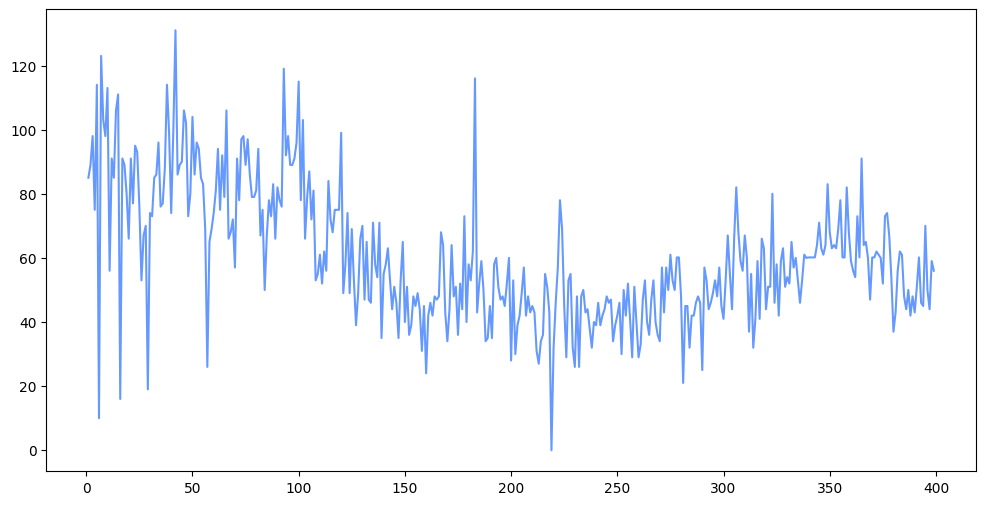

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(data['WEEK'], data['MOVE'], color = '#6699ff')

In [10]:
from copy import deepcopy as dc
import pandas as pd

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('WEEK', inplace=True) 
    
    for i in range(1, n_steps+1):
        df[f'Move(t-{i})'] = df['MOVE'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df


,MOVE,Move(t-1),Move(t-2),Move(t-3),Move(t-4),Move(t-5),Move(t-6),Move(t-7)
WEEK,,,,,,,,
8,103.0,123.0,10.0,114.000000,75.000000,98.000000,89.000000,85.000000
9,98.0,103.0,123.0,10.000000,114.000000,75.000000,98.000000,89.000000
10,113.0,98.0,103.0,123.000000,10.000000,114.000000,75.000000,98.000000
11,56.0,113.0,98.0,103.000000,123.000000,10.000000,114.000000,75.000000
12,91.0,56.0,113.0,98.000000,103.000000,123.000000,10.000000,114.000000
...,...,...,...,...,...,...,...,...
395,70.0,45.0,46.0,60.152455,51.000000,43.000000,48.000000,42.000000
396,50.0,70.0,45.0,46.000000,60.152455,51.000000,43.000000,48.000000
397,44.0,50.0,70.0,45.000000,46.000000,60.152455,51.000000,43.000000


In [11]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[103.        , 123.        ,  10.        , ...,  98.        ,
         89.        ,  85.        ],
       [ 98.        , 103.        , 123.        , ...,  75.        ,
         98.        ,  89.        ],
       [113.        ,  98.        , 103.        , ..., 114.        ,
         75.        ,  98.        ],
       ...,
       [ 44.        ,  50.        ,  70.        , ...,  60.15245478,
         51.        ,  43.        ],
       [ 59.        ,  44.        ,  50.        , ...,  46.        ,
         60.15245478,  51.        ],
       [ 56.        ,  59.        ,  44.        , ...,  45.        ,
         46.        ,  60.15245478]])

In [12]:
shifted_df_as_np.shape

(392, 8)

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[ 0.57251908,  0.8778626 , -0.84732824, ...,  0.49618321,
         0.35877863,  0.29770992],
       [ 0.49618321,  0.57251908,  0.8778626 , ...,  0.14503817,
         0.49618321,  0.35877863],
       [ 0.72519084,  0.49618321,  0.57251908, ...,  0.74045802,
         0.14503817,  0.49618321],
       ...,
       [-0.32824427, -0.23664122,  0.06870229, ..., -0.08164191,
        -0.22137405, -0.34351145],
       [-0.09923664, -0.32824427, -0.23664122, ..., -0.29770992,
        -0.08164191, -0.22137405],
       [-0.14503817, -0.09923664, -0.32824427, ..., -0.3129771 ,
        -0.29770992, -0.08164191]])

In [14]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((392, 7), (392,))

In [15]:
X = dc(np.flip(X, axis=1))
X

array([[ 0.29770992,  0.35877863,  0.49618321, ...,  0.74045802,
        -0.84732824,  0.8778626 ],
       [ 0.35877863,  0.49618321,  0.14503817, ..., -0.84732824,
         0.8778626 ,  0.57251908],
       [ 0.49618321,  0.14503817,  0.74045802, ...,  0.8778626 ,
         0.57251908,  0.49618321],
       ...,
       [-0.34351145, -0.22137405, -0.08164191, ..., -0.3129771 ,
         0.06870229, -0.23664122],
       [-0.22137405, -0.08164191, -0.29770992, ...,  0.06870229,
        -0.23664122, -0.32824427],
       [-0.08164191, -0.29770992, -0.3129771 , ..., -0.23664122,
        -0.32824427, -0.09923664]])

In [16]:
split_index = int(len(X) * 0.80)

split_index

313

In [17]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((313, 7), (79, 7), (313,), (79,))

In [18]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((313, 7, 1), (79, 7, 1), (313, 1), (79, 1))

In [19]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([313, 7, 1]),
 torch.Size([79, 7, 1]),
 torch.Size([313, 1]),
 torch.Size([79, 1]))

In [20]:
from torch.utils.data import Dataset

class SalesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = SalesDataset(X_train, y_train)
test_dataset = SalesDataset(X_test, y_test)

In [21]:
train_dataset

In [22]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [24]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [25]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 10 == 9:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [26]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [27]:
learning_rate = 0.001
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 10, Loss: 0.030
Batch 20, Loss: 0.030

Val Loss: 0.202
***************************************************

Epoch: 2
Batch 10, Loss: 0.026
Batch 20, Loss: 0.021

Val Loss: 0.140
***************************************************

Epoch: 3
Batch 10, Loss: 0.020
Batch 20, Loss: 0.016

Val Loss: 0.088
***************************************************

Epoch: 4
Batch 10, Loss: 0.014
Batch 20, Loss: 0.013

Val Loss: 0.052
***************************************************

Epoch: 5
Batch 10, Loss: 0.012
Batch 20, Loss: 0.008

Val Loss: 0.030
***************************************************

Epoch: 6
Batch 10, Loss: 0.008
Batch 20, Loss: 0.009

Val Loss: 0.022
***************************************************

Epoch: 7
Batch 10, Loss: 0.007
Batch 20, Loss: 0.008

Val Loss: 0.021
***************************************************

Epoch: 8
Batch 10, Loss: 0.007
Batch 20, Loss: 0.007

Val Loss: 0.021
***************************************************

Epoch: 9
Batch 1

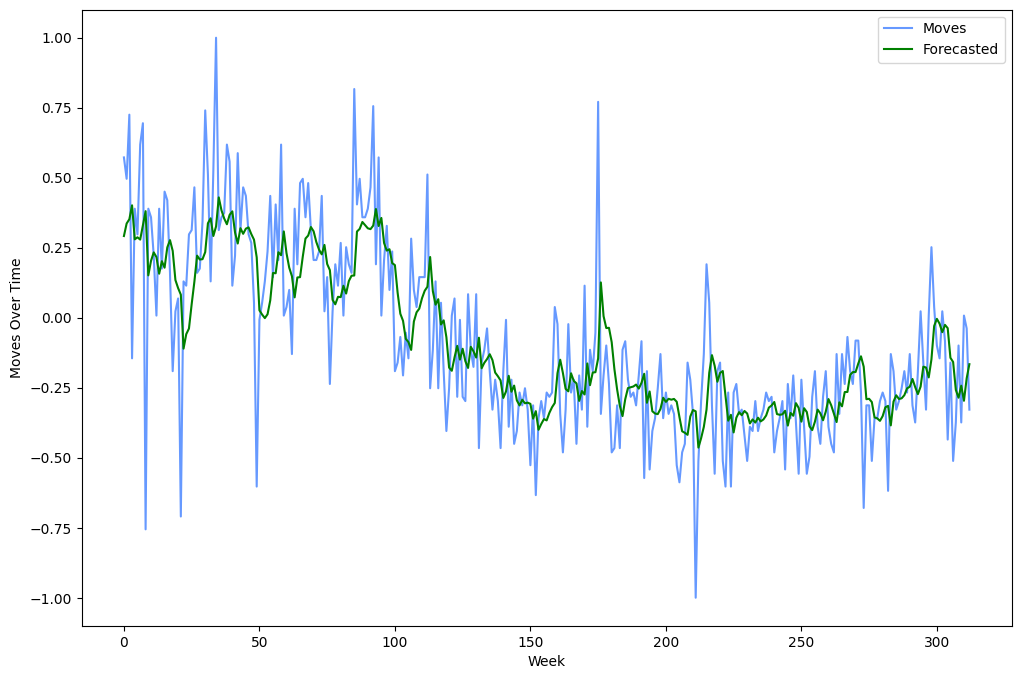

In [28]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.figure(figsize=(12, 8))
plt.plot(y_train, label='Moves', color = '#6699ff')
plt.plot(predicted, label='Forecasted', color = 'green')
plt.xlabel('Week')
plt.ylabel('Moves Over Time')
plt.legend()
plt.show()

In [29]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([84.60963567, 87.53566223, 88.53953432, 91.79430598, 83.8356919 ,
       84.3141672 , 83.77812198, 87.09133027, 90.42458615, 75.41578253,
       78.82194559, 80.78422061, 79.6868667 , 75.78985232, 78.72577287,
       77.1999523 , 81.94360487, 83.64824219, 81.13734488, 74.31648047,
       72.4214478 , 70.89303394, 58.2707292 , 61.65323339, 62.9669918 ,
       68.67355068, 73.92950273, 80.02258062, 79.11114797, 79.19716807,
       80.8496368 , 87.60236971, 88.75560892, 84.61998935, 86.86245997,
       93.64493337, 90.6304359 , 88.71146911, 87.36200573, 89.55167724,
       90.38415134, 85.44750719, 82.85418448, 86.44430894, 85.12726718,
       86.33843158, 86.63514546, 85.07405619, 83.76027437, 79.63710108,
       67.22509287, 66.24689223, 65.40638739, 66.30942817, 69.56796925,
       75.96162608, 75.90191573, 80.81811799, 80.12179172, 85.68828306,
       80.58620054, 77.21119417, 75.20968096, 70.26096337, 74.91427106,
       74.99116825, 79.7873193 , 84.0215175 , 84.72520691, 86.71

In [30]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([102.99999869,  98.00000069, 112.9999986 ,  55.99999969,
        91.00000036,  84.99999924, 105.99999827, 111.00000018,
        15.99999908,  91.00000036,  88.99999999,  80.00000026,
        66.        ,  91.00000036,  76.9999997 ,  94.99999915,
        93.00000073,  75.99999952,  53.00000011,  67.00000004,
        69.99999986,  18.99999866,  74.00000012,  72.99999993,
        84.99999924,  86.0000004 ,  96.00000031,  75.99999952,
        76.9999997 ,  88.00000077, 113.99999976,  99.00000185,
        74.00000012,  99.99999911, 131.        ,  86.0000004 ,
        88.99999999,  89.9999992 , 105.99999827, 102.00000143,
        72.99999993,  80.00000026, 103.99999985,  86.0000004 ,
        96.00000031,  93.99999994,  84.99999924,  83.00000082,
        68.99999992,  25.99999899,  65.        ,  68.99999992,
        74.00000012,  81.00000045,  93.99999994,  75.00000031,
        91.99999957,  79.00000007, 105.99999827,  66.        ,
        67.99999998,  72.00000023,  56.99999988,  91.00

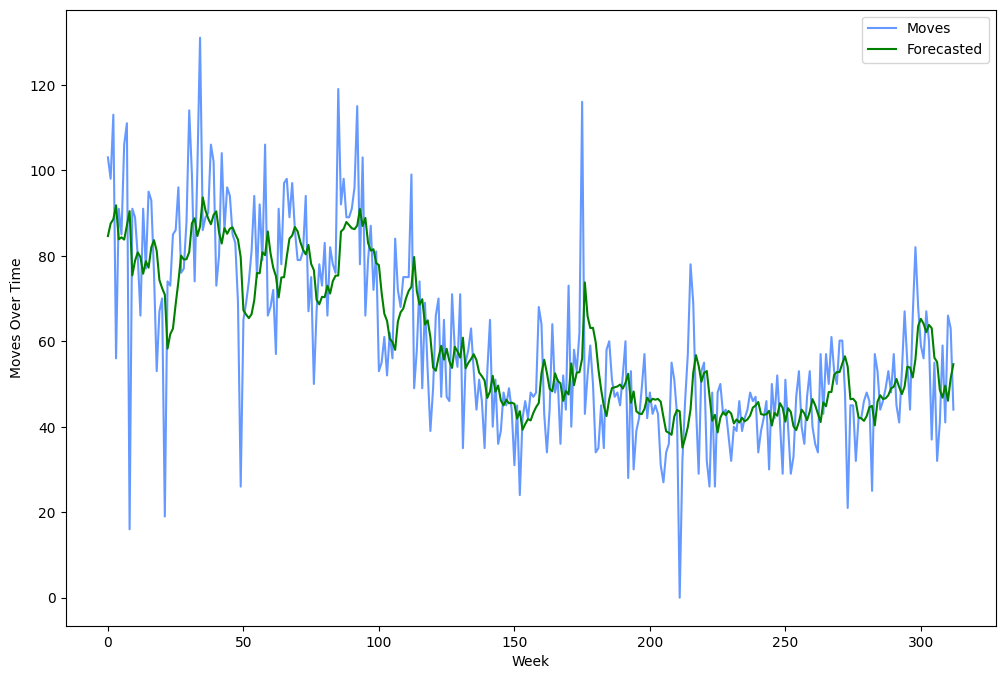

In [31]:
plt.figure(figsize=(12, 8))
plt.plot(new_y_train, label='Moves', color = '#6699ff')
plt.plot(train_predictions, label='Forecasted', color ='green')
plt.xlabel('Week')
plt.ylabel('Moves Over Time')
plt.legend()
plt.show()

In [32]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([51.67754044, 52.7378483 , 52.73655213, 60.28929554, 56.38527524,
       56.91070326, 52.80577581, 55.15947045, 57.14392664, 55.31644277,
       54.06851147, 53.83113803, 56.83071792, 57.05332409, 57.77864224,
       56.23985127, 53.84921794, 53.77855365, 55.60691789, 56.12241581,
       57.07341656, 57.8112825 , 58.68556565, 59.52168228, 60.92254905,
       63.64030923, 63.42867555, 62.94144529, 63.36019951, 68.92185561,
       68.62316822, 67.30497085, 66.38481447, 65.51269419, 66.41704285,
       69.38250868, 66.23151396, 64.70296736, 69.56367278, 68.96537466,
       66.4606517 , 63.65805729, 60.61246167, 63.91339351, 62.48522143,
       70.00464331, 68.14811486, 67.92634808, 66.27436931, 61.63292034,
       60.84580217, 60.19968463, 59.23084213, 59.37781213, 59.30831712,
       57.33427319, 62.19168355, 65.27915263, 65.81185204, 62.86957659,
       56.63211809, 53.44058315, 53.96350668, 54.84377287, 55.33575442,
       52.74944739, 50.8006513 , 51.40944169, 49.19400699, 48.70

In [33]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([50.99999974, 50.99999974, 80.00000026, 46.00000076, 58.00000007,
       42.00000001, 58.99999977, 63.00000002, 50.99999974, 54.0000003 ,
       51.99999993, 65.        , 56.99999988, 59.99999995, 53.00000011,
       46.00000076, 53.00000011, 61.00000014, 59.99999995, 60.15245473,
       60.15245473, 60.15245473, 60.15245473, 63.99999996, 71.00000005,
       63.00000002, 61.00000014, 63.99999996, 83.00000082, 67.99999998,
       63.00000002, 63.99999996, 63.00000002, 68.99999992, 77.99999989,
       60.15245473, 60.15245473, 81.99999966, 67.99999998, 58.99999977,
       55.99999969, 54.0000003 , 72.99999993, 60.15245473, 91.00000036,
       63.99999996, 65.        , 59.99999995, 46.99999997, 60.15245473,
       60.15245473, 62.00000008, 61.00000014, 59.99999995, 51.99999993,
       72.99999993, 74.00000012, 67.00000004, 54.0000003 , 37.00000006,
       42.99999923, 55.99999969, 62.00000008, 61.00000014, 47.99999918,
       44.00000039, 49.99999955, 42.00000001, 47.99999918, 42.99

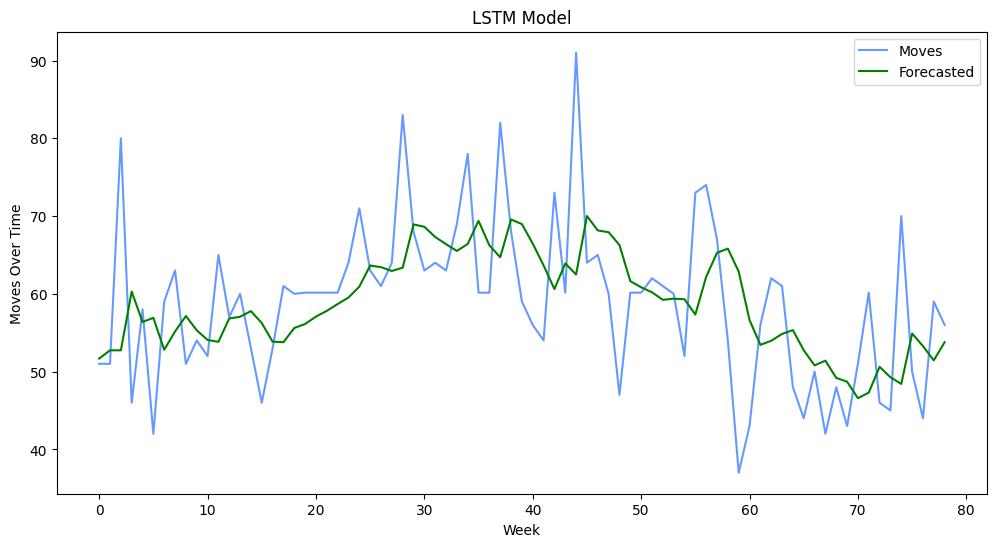

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(new_y_test, label='Moves',color = '#6699ff')
plt.plot(test_predictions, label='Forecasted', color = 'green')
plt.xlabel('Week')
plt.ylabel('Moves Over Time')
plt.title("LSTM Model")
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# report performance
mse = mean_squared_error(new_y_test, test_predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(new_y_test, test_predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(new_y_test, test_predictions))
print('RMSE: '+str(rmse))

MSE: 91.88320001238198
MAE: 7.145013831838777
RMSE: 9.585572492677835
